In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data collection and preprocessing

## Capture

You should now be able to start capture data for your object. Here are some general instructions

1. Go to a location where you know the lighting and background can be held constant for an extended period of time. (Best is a large, light controlled room).
1. You will have to be able to control the location of the brightest light source (spotlight/torchlight)
1. Place your object on the green point indicated on the chart drawing in Notebook 3. This should be the midpoint of the two markers you picked..
2. Setup your camera to use the sensitivity (ISO) that you have calibrated in Notebook 1
3. Setup your camera/lens to use the higher apterture number (F/) that it can achieve. This will allow you to to caputre both the subjet and the background
4. Set your camera to manual focus and tune it such that your object is in focus at a distance where your object occupies a decent portion of your frame and that you can see a decent (5+) number of crosshairs on the mirror.
6. With your camera point to brightest light source illuminating the scene and pick an exposure time such that the light source is not overexposed, let's call this time $T_-$
7. With your camera now point towards the darkest part of the object/scene and adjust the exposure time such that it is nicely exposed, let's denote this time $T_+$.
8. You will now setup your camera in exposure bracketing mode and program it to take multiple shots betweed $T_-$ and $T_+$. Depending on the dynamic range ($D$) of your camera and the ratio between $T_-$ and $T_+$ you might have to take more or less exposure $T_n$. But as a rule of thumb if $(log_2(T_+) - log_2(T_-)) / T_n \leq \frac{D}{4}$, you should be more than set.
9. Place your light source
10. Take $N$ shots of the object from various viewpoints
11. Move the light source (make sure you segregate your pictures for based on light source location) and repeat the previous step
12. Repeat the previous step $V$ times in total (The more reflection on your object, the larger the $V$
13. Regroup all your pictures and organize them in folders: `ROOT_FOLDER/LIGHT_SOURCE_LOCATION/IMAGE_ID.EXTENSION` where `LIGHT_SOURCE_LOCATION` goes from $0$ to $V - 1$ and `IMAGE_ID` is alphanumeric but sorted such that each group $T_n$ pictures is consecutive. for `EXTENSION` we should support all formats supported by `opencv` and `rawpy` but we have only tested Canon Camera Raw files so far (`CR2`, `CR3`).

In [6]:
ROOT_FOLDER = '/media/guillaumeleclerc/0123-4567/DCIM/perfume/'
EXTENSION = 'CR3'
SENSOR_CALIB_FILE = '/data/keoscope/calibration_R6mk2/sensor_response.npy'
MIRROR_CALIB_FILE = '/data/keoscope/calibration_R6mk2/mirror_calib.json'
LENS_CALIB_FILE = '/data/keoscope/calibration_R6mk2/50mm-f1.8-focus-close.json'
DATASET_DESTINATION = '/data2/keoscope/captures/perfume_three_envs_R6/'
T_N = 7

In [37]:
from glob import glob
import matplotlib.pyplot as plt
import os
from os import path
import numpy as np
import json
import warnings
import shutil

from mirrorSDF.optical_models import RGBImageSensor, Mirror, Lens
from mirrorSDF.utils.image import imread, read_hdr_stack
from mirrorSDF.aruco import prepare_image_for_aruco
from mirrorSDF.dataset import ShotMetadata
from mirrorSDF.dataset.preparation import process_image_first_stage, process_image_second_stage, segment_image, get_image_list_sorted
from mirrorSDF.config import MirrorSDFConfig, CalibrationFilesConfig, DatasetConfig

## Preparing the Data

Let's load the calibration for the sensor, the mirror and collect all the file names of your images

In [38]:
sensor = RGBImageSensor.from_disk(SENSOR_CALIB_FILE)
mirror = Mirror.from_disk(MIRROR_CALIB_FILE)
lens = Lens.from_disk(LENS_CALIB_FILE)

all_file_names = get_image_list_sorted(ROOT_FOLDER, EXTENSION, T_N)

## Adjusting the black and white point

Since your images might (should) have high dynamic range, it might make the detection of aruco markers tough, so we would like to know roughly what is the value of the dark part and the white part of the markers so that we have an easier way finding them.

Thankfully because all our measurement are calibrated once we have the proper value for a single image it will generalize to the whole dataset.

We will load an image and we will start as 1 and 99 percentile for the black and white point of our images. We will run the marker detection and you should ajust the black points and white points to maximize the number of markers detected.

Once you have a good value you can also change the image index and verify that it works on other images.

In [40]:
TEST_IMG_IX = 55
# TEST_IMG_IX = 63
image = read_hdr_stack(all_file_names[TEST_IMG_IX], sensor)

/home/guillaumeleclerc/mirrorSDF/mirrorSDF/utils/image.py:188: UserWarning: 9890763 under-exposed and 0         overexposed pixels in the image stack /media/guillaumeleclerc/0123-4567/DCIM/perfume/0/HU0A3296.CR3.../media/guillaumeleclerc/0123-4567/DCIM/perfume/0/HU0A3297.CR3
  warnings.warn(f"{under_exposed} under-exposed and {over_exposed} \


In [41]:
# Use percentiles
BLACK_POINT, WHITE_POINT = np.percentile(image, [1,  85])

# or custom value Adjust if necessary
BLACK_POINT, WHITE_POINT = 0.0025, 0.04

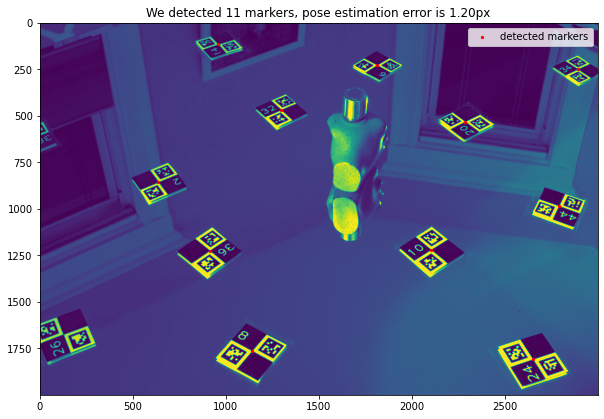

In [46]:
processed = prepare_image_for_aruco(image, low=BLACK_POINT, high=WHITE_POINT)
test = mirror.crosshair_field.detect_crosshairs(processed)[0].reshape(-1, 2)
try:
    _, error = mirror.estimate_camera_pose(processed, lens)
except:
    error = np.inf
    

plt.figure(figsize=(10, 10))
plt.imshow(processed)
plt.scatter(*test.T, color='red', s=5, label='detected markers')
plt.title(f"We detected {len(test)} markers, pose estimation error is {error:.2f}px")
plt.legend()
None

## Review segmentation and adjust margins

We will run the pre-processing pipeline on the same image and you will be able to adjust a couple parameters

In [47]:
result = process_image_first_stage(TEST_IMG_IX,
                                   all_file_names[TEST_IMG_IX],
                                   sensor, lens, mirror,
                                   BLACK_POINT, WHITE_POINT)
pixels, loaded_image, origin, directions, shot_metadata, camera = result

/home/guillaumeleclerc/mirrorSDF/mirrorSDF/utils/image.py:188: UserWarning: 9890763 under-exposed and 0         overexposed pixels in the image stack /media/guillaumeleclerc/0123-4567/DCIM/perfume/0/HU0A3296.CR3.../media/guillaumeleclerc/0123-4567/DCIM/perfume/0/HU0A3297.CR3
  warnings.warn(f"{under_exposed} under-exposed and {over_exposed} \


In [48]:
# Center of the object Should be (0, 0, 0) if you placed it properly
# But I'm extra nice so I let you fix it now if you messed up
OBJECT_CENTER = np.zeros(3) 

# A box (width, depth, height) centered around the object that encloses your object
# The tighter you can make it the better
OBJECT_BOUNDING_BOX=np.full(3, 85)

# Distance to discard around the mirror
# This is important as we definitely don't want to train on border/bezels of the mirror
# Training on the floor is usually ok but if you don't you can make this very large
# to discard any ray that doesn't hit the mirror
MIRROR_SAFETY_PADDING = 90

# People are never perfect when cutting markers so we usually discard a region around them
# to make sure we only train on high quality data
# This is especially true if you used tape to glue your markers as the tape will
# be larger than the marker so make sure you increase this value until we discard any tape
MARKER_SAFETY_PADDING = 10

# This quantity is the smallest distance (in mm) between the center of object to anything
# in the environment (This includes any part of the floor that might be visible from your
# shots). The larger you can make this, by being in a larger room, or elevating the mirror
# from the floor the better. If you can only eyeball this quantity, use a lower bound.
MIN_ENV_DISTANCE_MM =  1000
# Similarly this is largest distance between the center of the object and your environment.
# If your environment is unbounded use the distance to the farthest object that could cause
# parallax effects
MAX_ENV_DISTANCE_MM =  5000

## Segmentation Generation

We use the settings above to generate a segmentation for you to review

In [49]:
train_object, train_env = segment_image(origin[None], directions, mirror.mirror_corners_clockwise[None],
                  mirror.crosshair_corners.copy(), OBJECT_CENTER, OBJECT_BOUNDING_BOX,
                  mirror.thickness_mm, MIRROR_SAFETY_PADDING, MARKER_SAFETY_PADDING, 1 / mirror.ior)

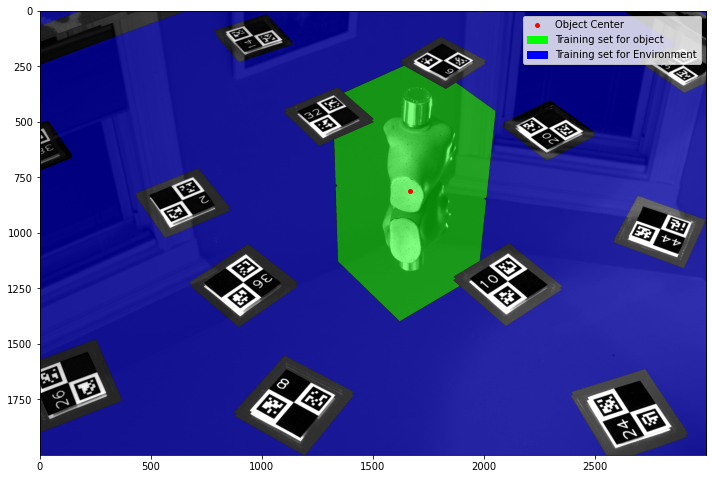

In [50]:
import matplotlib.patches as mpatches

object_center = camera.project(np.zeros((1, 3)))
shape_mask = np.array([0, 1.0, 0.0, 1.0])[None] * train_object.numpy()[:, None]
env_mask = np.array([0, 0, 1, 1.0])[None] * train_env.numpy()[:, None]

plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.scatter(*object_center.T, color='red', s=15, label='Object Center')
plt.imshow(processed, cmap='gray')
plt.imshow(shape_mask.reshape(*image.shape[:2], 4), alpha=0.5, label="Used for training shape")
plt.imshow(env_mask.reshape(*image.shape[:2], 4), alpha=0.5, label="Used for training environ.")
plt.tight_layout()

green_patch = mpatches.Patch(color='#0F0', label='Training set for object')
blue_patch = mpatches.Patch(color='#00F', label='Training set for Environment')

handles, labels = ax.get_legend_handles_labels()
handles.extend([green_patch, blue_patch])
labels.extend(['Training set for object', 'Training set for Environment'])

# Add the custom legend to the plot
ax.legend(handles=handles, labels=labels)

## Writing the dataset chunk for this image

Just to test that everything is working we will generate the slice for this image. If no error persist we will run it on the entire dataset

In [51]:
os.makedirs(DATASET_DESTINATION, exist_ok=True)

process_image_second_stage(shot_metadata, loaded_image, DATASET_DESTINATION, pixels,
                          origin, directions, mirror, OBJECT_CENTER, OBJECT_BOUNDING_BOX,
                          MIRROR_SAFETY_PADDING, MARKER_SAFETY_PADDING)

## Genrating a config file

We will generate a config file containing all the information you entered so that you can run our command line tools on multiple machines and are not limited to run in a notebook.
If you wish to change hyper paramters or anything you can add entries you want to customize here

Note that we will copy your calibration files to the directory too so that everything stays together.

In [55]:
config = MirrorSDFConfig(
    calibration_files = CalibrationFilesConfig(
        sensor = path.join(DATASET_DESTINATION, 'sensor.npy'),
        lens = path.join(DATASET_DESTINATION, 'lens.json'),
        mirror = path.join(DATASET_DESTINATION, 'mirror.json')
    ),
    dataset = DatasetConfig(
        original_source = ROOT_FOLDER,
        num_environments=len(glob(path.join(ROOT_FOLDER, '*'))),
        num_images = all_file_names.shape[0],
        images_height = processed.shape[0],
        images_width = processed.shape[1],
        source_extension = EXTENSION,
        num_bracketed_shots = T_N,
        root = DATASET_DESTINATION,
        white_point = WHITE_POINT,
        black_point = BLACK_POINT,
        object_center = OBJECT_CENTER,
        object_bounding_box = OBJECT_BOUNDING_BOX,
        mirror_safety_padding = MIRROR_SAFETY_PADDING,
        marker_safety_padding = MARKER_SAFETY_PADDING,
        minimum_distance_to_env = MIN_ENV_DISTANCE_MM,
        maximum_distance_to_env = MAX_ENV_DISTANCE_MM
    )
)

# For advanced users you can change default arguments to your liking
# It's also possible to change the json generated too
# config.pre_training.batch_size = 1024

config_dest = path.join(DATASET_DESTINATION, 'config.json')
config.to_disk(config_dest)

# We copy your config files into the destination folder just so that everything
# is all together

shutil.copy(SENSOR_CALIB_FILE, path.join(DATASET_DESTINATION, 'sensor.npy'))
shutil.copy(LENS_CALIB_FILE, path.join(DATASET_DESTINATION, 'lens.json'))
shutil.copy(MIRROR_CALIB_FILE, path.join(DATASET_DESTINATION, 'mirror.json'))
None

[autoreload of mirrorSDF.config.root failed: Traceback (most recent call last):
  File "/home/guillaumeleclerc/miniconda3/envs/ffcv_new/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/guillaumeleclerc/miniconda3/envs/ffcv_new/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/home/guillaumeleclerc/miniconda3/envs/ffcv_new/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/guillaumeleclerc/miniconda3/envs/ffcv_new/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/guillaumeleclerc/miniconda3/envs/ffcv_new/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/guillaumeleclerc/minico

In [23]:
MirrorSDFConfig.from_disk(config_dest)

MirrorSDFConfig(calibration_files=CalibrationFilesConfig(sensor='/data2/keoscope/captures/perfume_three_envs_R6/sensor.npy', lens='/data2/keoscope/captures/perfume_three_envs_R6/lens.json', mirror='/data2/keoscope/captures/perfume_three_envs_R6/mirror.json'), dataset=DatasetConfig(original_source='/media/guillaumeleclerc/0123-4567/DCIM/perfume/', num_images=278, num_environments=3, images_height=2000, images_width=3000, source_extension='CR3', num_bracketed_shots=7, root='/data2/keoscope/captures/perfume_three_envs_R6/', white_point=0.04, black_point=0.0025, object_center=array([0., 0., 0.]), object_bounding_box=array([85, 85, 85]), mirror_safety_padding=90, marker_safety_padding=10, minimum_distance_to_env=1000, maximum_distance_to_env=5000, maximum_measurement=None), architecture=ArchitectureConfig(background=BackgroundConfig(num_layers=5, environ_encoding_dim=32, coord_encoding_dim=128, min_frequency=6.283185307179586, max_frequency=6283.185307179586, model_occlusions=True)), pre_tr

## Generating your dataset

The dataset generation follow the map-reduce framework. We will process (map) each image and then aggregate (reduce) all the data in a single file. The first stage can be run in parallel (on a single machine or as many as you want)

### Map

The command to process an image of the dataset is

```
python -m mirrorSDF.dataset.generate_map -c CONFIG_FILE -i IMAGE_INDEX -d DEVICE
```

Where device is the pytorch device you want to use for the segmentation. Since the GPU is only used for segmentation it's ok to assign multiple jobs onto the same device if you wish to do so.

You will have to run this command for IMAGE_INDEX from 0 to the number of images you have minus 1. As a reminder:

In [53]:
print("You have",all_file_names.shape[0], "images in your dataset")

You have 278 images in your dataset


If you have a cluster feel free to run this on as many machines as you want, but for the sake of this demonstration we will show the simple case of a single machine and single GPU

In [54]:
script = "python -m mirrorSDF.dataset.generate_map"
max_index = all_file_names.shape[0] - 1
max_concurrent_jobs = 4
command = f"parallel -j {max_concurrent_jobs} --bar '{script} -i {{}} -d cuda:0 -c {config_dest}' ::: $(seq 0 {max_index})"
print(command)

parallel -j 4 --bar 'python -m mirrorSDF.dataset.generate_map -i {} -d cuda:0 -c /data2/keoscope/captures/perfume_three_envs_R6/config.json' ::: $(seq 0 277)


### Sanity check

We will just plot for each image how many markers and what was the reprojection error to identify bad images (you probably should delete the corresponding shard before merging)

In [ ]:
ids = []
rmse = []
markers_detected = []
for i in range(0, max_index + 1):
    try:
        shot_metadata = ShotMetadata.from_file(config.dataset.root, i)
        ids.append(shot_metadata.shot_id)
        rmse.append(shot_metadata.pose_est_rmse)
        markers_detected.append(shot_metadata.num_markers_available)
    except:
        warnings.warn(f"Image {i} missing !!")

If you have missing images you can go back to the top of the notebook and try to visualize them to tune your white and black points. If they are just bad you can ignore the warning.
After adjusting the white/black points. you should rerun the command to generate their shard. No need to rerun the whole thing just the ones that were bad but if you think that other images might benefit from these new white and black points then you can do so.

In [ ]:
# plt.figure(figsize=(10, 10))
fig, axes = plt.subplots(3, 1)

fig.set_size_inches(12, 18)
axes[0].bar(ids, rmse, label='RMSE by image')
axes[0].set_title('Reprojection_error')
axes[0].set_xlabel('Image Idx')
axes[0].set_ylabel('Reprojection error (px)')
axes[0].axhline(np.mean(rmse), label='Average RMSE', color='red')
axes[0].legend()
axes[0].grid()

axes[1].bar(ids, markers_detected, label='Num markers by image id')
axes[1].set_title('Number of markers detected')
axes[1].set_xlabel('Image Idx')
axes[1].set_ylabel('Markers Detected')
axes[1].axhline(np.mean(markers_detected), label='Average num. markers', color='red')
axes[1].legend()
axes[1].grid()

axes[2].scatter(markers_detected, rmse)
axes[2].set_title('Num markers vs RMSE')
axes[2].set_xlabel('Number of markers detected')
axes[2].set_ylabel('Reprojectio nerror (px)')
axes[2].grid()


### Reduce

The command to reduce all the shard into a single dataset

```
python -m mirrorSDF.dataset.generate_reduce -c CONFIG_FILE -r
```

This command can only run into a single process but it only involves copying data around so it should be relatively fast (limited by your storage). If you want to keep the individual shards you have to remove the `-r` flag.

For you the command should be:

In [28]:
print(f"python -m mirrorSDF.dataset.generate_reduce -c {config_dest} -r")

python -m mirrorSDF.dataset.generate_reduce -c /data2/keoscope/captures/perfume_three_envs_R6/config.json -r


### Reduce

The command to reduce all the shard into a single dataset

```
python -m mirrorSDF.dataset.generate_reduce -c CONFIG_FILE -r
```

This command can only run into a single process but it only involves copying data around so it should be relatively fast (limited by your storage). If you want to keep the individual shards you have to remove the `-r` flag.

## Congratulation

You can now move to the next step of the pipeline: Fitting a model for your environment